## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from my_utils import split_and_train, split_and_train_conferences_together, train_evaluate_decision_tree_graph_old
from my_utils import train_evaluate_decision_tree_graph, train_evaluate_decision_tree_average, train_evaluate_decision_tree_years_back
from my_utils import plot_metrics_over_time, plot_metrics_over_time_test_train, plot_metrics_over_time_three
from my_utils import backwards_elimination, select_k_best

In [3]:
df_awards_players = pd.read_csv('data/awards_players_processed.csv')
df_coaches_before = pd.read_csv('data/coaches.csv')
df_players_teams_before = pd.read_csv('data/players_teams.csv')
df_players = pd.read_csv('data/players_processed.csv')
df_series_post = pd.read_csv('data/series_post_processed.csv')
df_teams_before = pd.read_csv('data/teams.csv')
df_teams_post = pd.read_csv('data/teams_post_processed.csv')
df_teams_11 = pd.read_csv('data/11year/teams.csv')
df_players_teams_11 = pd.read_csv('data/11year/players_teams.csv')
df_coaches_11 = pd.read_csv('data/11year/coaches.csv')

## Clean up 11 year data

In [4]:

def drop_columns_with_all_nan(df):
    # Step 1: Check for columns with all NaN values
    columns_to_drop = []
    for col in df.columns:
        unique_values = df[col].unique()
        if len(unique_values) == 1 or all(pd.isna(x) for x in unique_values):
            columns_to_drop.append(col)

    # Step 2: Drop identified columns
    df.drop(columns=columns_to_drop, inplace=True)

    # Step 3: Print the identified columns to be dropped
    print(columns_to_drop)




In [5]:
drop_columns_with_all_nan(df_teams_before)
print(df_teams_before.duplicated().sum())
df_teams_before.drop_duplicates(inplace=True)


drop_columns_with_all_nan(df_players_teams_before)
print(df_players_teams_before.duplicated().sum())
df_players_teams_before.drop_duplicates(inplace=True)

drop_columns_with_all_nan(df_coaches_before)
print(df_coaches_before.duplicated().sum())
print(df_coaches_before.duplicated(subset=['tmID', 'year']).sum())
df_coaches_before.drop_duplicates(inplace=True)




['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
0
['lgID']
0
['lgID']
0
20


In [6]:
df_teams_11.drop(['lgID','franchID','name','arena'], axis=1, inplace=True)
df_players_teams_11.drop(['stint','lgID'], axis=1, inplace=True)
df_coaches_11.drop(['stint','lgID'], axis=1, inplace=True)

## Merge datasets

Agregate the data from series_post by the number of wins of each player and the number of losses, then join it to the Teams dataset 

In [7]:
# concat df_teams_11 and df_teams with the common columns and the rest of the columns 0
df_teams_before = pd.concat([df_teams_before, df_teams_11], axis=0, ignore_index=True)
df_teams_before.fillna(0, inplace=True)

In [8]:
df_teams_before['playoff'] = df_teams_before['playoff'].map({'N': 0, 'Y': 1})
years = df_teams_before['year'].unique()
teams = df_teams_before['tmID'].unique()
df_teams_before.sort_values(by=['year', 'tmID'], ascending=[True, True], inplace=True)

years_back = 2

df_teams = df_teams_before.copy()

average_collumns = ["homeW","homeL","awayW","awayL","confW","confL","min","attend"]

for year in years:
    for team in teams:
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'num_playoff_appearances'] = df_teams_before[(df_teams_before['year'] >= (year - years_back)) & (df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['playoff'].sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_first_round_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['firstRound'] == 'W').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_first_round_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['firstRound'] == 'L').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_semis_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['semis'] == 'W').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_semis_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['semis'] == 'L').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_finals_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['finals'] == 'W').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_finals_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['finals'] == 'L').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'mean_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['won']).mean()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'mean_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['lost']).mean()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'rank'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['rank']).mean()
        for column in average_collumns:
            df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), column] = df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)][column].mean()
 
         
df_teams.drop(columns=['firstRound', 'semis', 'finals',"won","lost", 'franchID', 'name', 'arena', "o_fgm","o_fga","o_ftm","o_fta","o_3pm","o_3pa","o_oreb","o_dreb","o_reb","o_asts","o_pf","o_stl","o_to","o_blk","o_pts","d_fgm","d_fga","d_ftm","d_fta","d_3pm","d_3pa","d_oreb","d_dreb","d_reb","d_asts","d_pf","d_stl","d_to","d_blk","d_pts","GP"], inplace=True)
df_teams.fillna(0, inplace=True)   

encoder = OneHotEncoder()
categorical_features = ['confID']
for feature in categorical_features:
    onehotarray = encoder.fit_transform(df_teams[[feature]]).toarray()
    items = [f'{feature}_{item}' for item in encoder.categories_[0]]
    df_teams[items] = onehotarray
df_teams=df_teams.drop(categorical_features, axis=1)

In [9]:
df_players_teams_before = pd.concat([df_players_teams_before, df_players_teams_11], axis=0, ignore_index=True)
df_players_teams_before.fillna(0, inplace=True)

In [10]:
df_players_teams = df_players_teams_before.copy()

average_collumns = ["GP","GS","minutes","points","oRebounds","dRebounds","rebounds","assists","steals","blocks","turnovers","PF","fgAttempted","fgMade","ftAttempted","ftMade","threeAttempted","threeMade","dq","PostGP","PostGS","PostMinutes","PostPoints","PostoRebounds","PostdRebounds","PostRebounds","PostAssists","PostSteals","PostBlocks","PostTurnovers","PostPF","PostfgAttempted","PostfgMade","PostftAttempted","PostftMade","PostthreeAttempted","PostthreeMade","PostDQ"]
for year in years:
    for team in teams:
        players = df_players_teams_before[(df_players_teams_before['year'] == year) & (df_players_teams_before['tmID'] == team)]['playerID'].unique()
        for player in players:
            for column in average_collumns:
                df_players_teams.loc[(df_players_teams['year'] == year) & (df_players_teams['tmID'] == team) & (df_players_teams['playerID'] == player), column] = df_players_teams_before[(df_players_teams['year'] >= (year - years_back)) &(df_players_teams['year'] < year)  & (df_players_teams['playerID'] == player)][column].mean()

df_players_teams.dropna(inplace=True)
df_players_teams.drop(columns=['stint'], inplace=True)

print(df_players_teams_before.info(), df_players_teams.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playerID            2024 non-null   object 
 1   year                2024 non-null   int64  
 2   stint               2024 non-null   float64
 3   tmID                2024 non-null   object 
 4   GP                  2024 non-null   float64
 5   GS                  2024 non-null   float64
 6   minutes             2024 non-null   float64
 7   points              2024 non-null   float64
 8   oRebounds           2024 non-null   float64
 9   dRebounds           2024 non-null   float64
 10  rebounds            2024 non-null   float64
 11  assists             2024 non-null   float64
 12  steals              2024 non-null   float64
 13  blocks              2024 non-null   float64
 14  turnovers           2024 non-null   float64
 15  PF                  2024 non-null   float64
 16  fgAtte

In [11]:
df_coaches_before = pd.concat([df_coaches_before,df_coaches_11], axis=0, ignore_index=True)
df_coaches_before.fillna(0, inplace=True)

In [12]:
df_coaches = df_coaches_before.copy()

average_collumns = ["won","lost","post_wins","post_losses"]
for year in years:
    for team in teams:
        coaches= df_coaches_before[(df_coaches_before['year'] == year) & (df_coaches_before['tmID'] == team)]['coachID'].unique()
        for coach in coaches:
            for column in average_collumns:
                df_coaches.loc[(df_coaches['year'] == year) & (df_coaches['tmID'] == team) & (df_coaches['coachID'] == coach), column] = df_coaches_before[(df_coaches_before['year'] >= (year - years_back)) &(df_coaches_before['year'] < year) & (df_coaches_before['coachID'] == coach)][column].mean()         

df_coaches.fillna(0, inplace=True)


Agregate data from players team, players info and awards and join it to the Teams dataset

In [13]:
players_teams_info_df = pd.merge(df_players_teams, df_players, left_on='playerID', right_on='bioID', how='left')
players_teams_info_df = pd.merge(players_teams_info_df, df_awards_players, on=['playerID', 'year'], how='left').fillna(0)
players_teams_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playerID            1392 non-null   object 
 1   year                1392 non-null   int64  
 2   tmID                1392 non-null   object 
 3   GP                  1392 non-null   float64
 4   GS                  1392 non-null   float64
 5   minutes             1392 non-null   float64
 6   points              1392 non-null   float64
 7   oRebounds           1392 non-null   float64
 8   dRebounds           1392 non-null   float64
 9   rebounds            1392 non-null   float64
 10  assists             1392 non-null   float64
 11  steals              1392 non-null   float64
 12  blocks              1392 non-null   float64
 13  turnovers           1392 non-null   float64
 14  PF                  1392 non-null   float64
 15  fgAttempted         1392 non-null   float64
 16  fgMade

For each team and year agregate the statistics of the players in the team and join it to the Teams dataset.

In [14]:
agg_players_df = players_teams_info_df.groupby(["year", "tmID"]).agg({
    "GP": "mean",
    "GS": "mean",
    "minutes": "mean",
    "points": "mean",
    "oRebounds": "mean",
    "dRebounds": "mean",
    "rebounds": "mean",
    "assists": "mean",
    "steals": "mean",
    "blocks": "mean",
    "turnovers": "mean",
    "PF": "mean",
    "fgAttempted": "mean",
    "fgMade": "mean",
    "ftAttempted": "mean",
    "ftMade": "mean",
    "threeAttempted": "mean",
    "threeMade": "mean",
    "dq": "mean",
    "PostGP": "mean",
    "PostGS": "mean",
    "PostMinutes": "mean",
    "PostPoints": "mean",
    "PostoRebounds": "mean",
    "PostdRebounds": "mean",
    "PostRebounds": "mean",
    "PostAssists": "mean",
    "PostSteals": "mean",
    "PostBlocks": "mean",
    "PostTurnovers": "mean",
    "PostPF": "mean",
    "PostfgAttempted": "mean",
    "PostfgMade": "mean",
    "PostftAttempted": "mean",
    "PostftMade": "mean",
    "PostthreeAttempted": "mean",
    "PostthreeMade": "mean",
    "PostDQ": "mean",
    "height": "mean",
    "weight": "mean",
    "award_count": "mean",

    # Add more columns you want to aggregate here
}).reset_index()

df_teams = pd.merge(df_teams, agg_players_df, on=['year', 'tmID'], how='left').fillna(0)
#agg_players_df.head()

In [15]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     154 non-null    int64  
 1   tmID                     154 non-null    object 
 2   rank                     154 non-null    float64
 3   playoff                  154 non-null    float64
 4   homeW                    154 non-null    float64
 5   homeL                    154 non-null    float64
 6   awayW                    154 non-null    float64
 7   awayL                    154 non-null    float64
 8   confW                    154 non-null    float64
 9   confL                    154 non-null    float64
 10  min                      154 non-null    float64
 11  attend                   154 non-null    float64
 12  num_playoff_appearances  154 non-null    float64
 13  total_first_round_won    154 non-null    float64
 14  total_first_round_lost   1

Merge team information with coach information

In [16]:
df_coaches_with_awards = pd.merge(df_coaches, df_awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left').fillna(0)
df_coaches_with_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   coachID      176 non-null    object 
 1   year         176 non-null    int64  
 2   tmID         176 non-null    object 
 3   stint        176 non-null    float64
 4   won          176 non-null    float64
 5   lost         176 non-null    float64
 6   post_wins    176 non-null    float64
 7   post_losses  176 non-null    float64
 8   playerID     176 non-null    object 
 9   award_count  176 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 13.9+ KB


In [17]:
agg_coaches_df = df_coaches_with_awards.groupby(["year", "tmID"]).agg({
    "won": "mean",
    "lost": "mean",
    "post_wins": "mean",
    "post_losses": "mean",
    "award_count": "mean",
}).reset_index()

df_teams = pd.merge(df_teams, agg_coaches_df, on=['year', 'tmID'], how='left')
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 69 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     154 non-null    int64  
 1   tmID                     154 non-null    object 
 2   rank                     154 non-null    float64
 3   playoff                  154 non-null    float64
 4   homeW                    154 non-null    float64
 5   homeL                    154 non-null    float64
 6   awayW                    154 non-null    float64
 7   awayL                    154 non-null    float64
 8   confW                    154 non-null    float64
 9   confL                    154 non-null    float64
 10  min                      154 non-null    float64
 11  attend                   154 non-null    float64
 12  num_playoff_appearances  154 non-null    float64
 13  total_first_round_won    154 non-null    float64
 14  total_first_round_lost   1

Merges the teams with teams post and added the value 0 to the teams that did not have any wins or losses

In [18]:
df_teams.to_csv('data_merged_11.csv', index=False)

# Feature selection

## Agregation and manual selection

In [19]:
df_teams = pd.read_csv('data_merged_11.csv')
df_teams['performance'] = (df_teams['points'] + df_teams['rebounds'] +
                            df_teams['assists'] + df_teams['steals'] +
                            df_teams['blocks']) - (df_teams['turnovers'] +
                            0.4*df_teams['PF'])
df_teams['Postperformance'] = (df_teams['PostPoints'] + df_teams['PostRebounds'] +
                            df_teams['PostAssists'] + df_teams['PostSteals'] +
                            df_teams['PostBlocks']) - (df_teams['PostTurnovers'] +
                            0.4*df_teams['PostPF'])
                            
df_teams.drop(columns=['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF'], inplace=True)

In basketball, one can calculate the total points scored using the following formula:
Total Points = Free Throws Made (ftMade) + 2 * (Field Goals Made (fgMade) - Three-Pointers Made (threeMade)) + 3 * Three-Pointers Made (threeMade).
However, it's important to note that the given dataset already includes a dedicated column for total points. Consequently, the columns for Free Throws Made (ftMade), Field Goals Made (fgMade), and Three-Pointers Made (threeMade)  end up giving redundant information, and therefore, are not useful and can be deleted from the dataset.

In [20]:
points_made = 1 * df_teams['ftMade'] + 2 * (df_teams['fgMade'] - df_teams['threeMade']) + 3 * df_teams['threeMade']
points_attempted = 1 * df_teams['ftAttempted'] + 2 * (df_teams['fgAttempted'] - df_teams['threeAttempted']) + 3 * df_teams['threeAttempted']
df_teams['points_precision'] = points_attempted - points_made

post_points_made = 1 * df_teams['PostftMade'] + 2 * (df_teams['PostfgMade'] - df_teams['PostthreeMade']) + 3 * df_teams['PostthreeMade']
post_points_attempted = 1 * df_teams['PostftAttempted'] + 2 * (df_teams['PostfgAttempted'] - df_teams['PostthreeAttempted']) + 3 * df_teams['PostthreeAttempted']
df_teams['Postpoints_precision'] = post_points_attempted - post_points_made

df_teams.drop(columns=['ftMade', 'fgMade', 'threeMade', 'fgAttempted', 'ftAttempted', 'threeAttempted', 'PostftMade', 'PostfgMade', 'PostthreeMade', 'PostfgAttempted', 'PostftAttempted', 'PostthreeAttempted'], inplace=True)

The "won" and "lost" collumns is the sum of  "homeW","awayW", "homeL","awayL"


In [21]:
df_teams.drop(columns=["homeW","homeL","awayW","awayL"], inplace=True)

In [22]:
df_teams.drop(columns=["oRebounds", "dRebounds", "PostoRebounds", "PostdRebounds"], inplace=True)

## Voting classifier

In [23]:

df_teams = df_teams[df_teams['year'] != 1]
df_teams = df_teams[df_teams['year'] != 2]

#one hot encoding sklearn to encode column tmID
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df_teams[['tmID']]).toarray()
items = [f'tmID_{item}' for item in encoder.categories_[0]]
df_teams[items] = onehotarray
df_teams=df_teams.drop(['tmID'], axis=1)
df_teams[df_teams['year'] ==11].head(14)

,year,rank,playoff,confW,confL,min,attend,num_playoff_appearances,total_first_round_won,total_first_round_lost,...,tmID_NYL,tmID_ORL,tmID_PHO,tmID_POR,tmID_SAC,tmID_SAS,tmID_SEA,tmID_TUL,tmID_UTA,tmID_WAS
142,11,4.5,0.0,6.0,15.0,6887.5,131058.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,11,5.0,0.0,10.0,11.0,6850.0,64499.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,11,4.0,0.0,11.5,9.5,6912.5,122723.5,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,11,2.5,0.0,14.5,6.5,6937.5,132952.5,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,11,3.0,0.0,11.5,8.5,6962.5,169113.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,11,6.0,0.0,7.5,12.5,6887.5,123295.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,11,5.0,0.0,10.0,11.0,6900.0,160188.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,11,3.5,0.0,10.5,9.5,6862.5,144875.5,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,11,2.5,0.0,10.0,10.0,6900.0,131839.5,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
151,11,2.0,0.0,13.0,7.0,6912.5,137180.5,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb


# First Model
model1 = LogisticRegression(C=0.01, class_weight='balanced', max_iter=200, multi_class='auto', penalty='l2', solver='lbfgs')

# Second Model
model2 = GaussianNB(priors=None, var_smoothing=1e-09)

## Third Model
model3 = KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski', n_neighbors=10, p=2)
model4 = MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(20,), max_iter=100, solver='adam', early_stopping=True)

hightest_accuracy_score:  0.7728937728937728


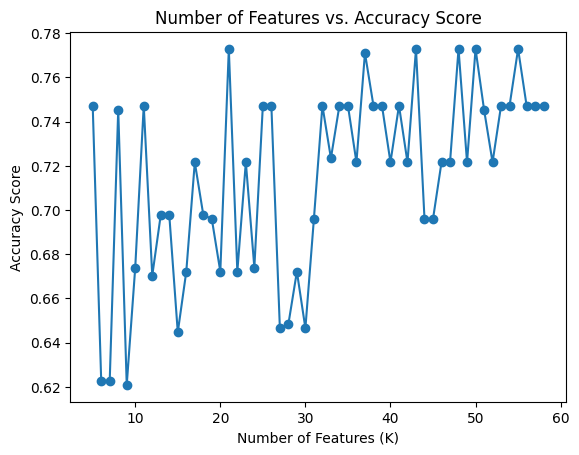

Index(['rank', 'confW', 'num_playoff_appearances', 'total_first_round_won',
       'total_semis_won', 'mean_lost', 'confID_EA', 'GS', 'minutes', 'PostGS',
       'PostMinutes', 'PostDQ', 'post_wins', 'post_losses', 'performance',
       'Postperformance', 'points_precision', 'tmID_DET', 'tmID_IND',
       'tmID_MIN', 'tmID_ORL', 'playoff', 'year', 'confID_WE', 'tmID_ATL',
       'tmID_CHA', 'tmID_CHI', 'tmID_CLE', 'tmID_CON', 'tmID_HOU', 'tmID_LAS',
       'tmID_MIA', 'tmID_NYL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC', 'tmID_SAS',
       'tmID_SEA', 'tmID_UTA', 'tmID_WAS', 'tmID_TUL'],
      dtype='object')


In [34]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('model1', model1),
    ('model2', model2),
    ('model3', model3),
    ('model4', model4)
], voting='soft')

# Extract the target variable
target_variable = df_teams["playoff"]

# Fit the ensemble model
voting_clf.fit(df_teams, target_variable)

features_kbest = select_k_best(df_teams[df_teams["year"] < 11], voting_clf, scaling=True)
print(features_kbest)



In [35]:
data = df_teams[features_kbest]
target_col = "playoff"
# Split the data into training and test sets
train_data = data[data["year"] < 11]
train_data = train_data[train_data["year"] >= 11 - 4]
test_data = data[data["year"] == 11]

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns=data.columns)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(test_data, columns=data.columns)

X_train = train_data.drop([target_col], axis=1)
y_train = train_data[target_col]
X_test = test_data.drop([target_col], axis=1)

voting_clf.fit(X_train, y_train)
y_prob = voting_clf.predict_proba(X_test)

test_data = test_data.copy()
test_data.loc[:, 'y_prob'] = y_prob[:, 1]
test_data['y_pred'] = 0
conferences = ['confID_EA', 'confID_WE']
for conf_col in conferences:
    conf_indices = test_data.index[test_data[conf_col] == 1].tolist()
    sorted_indices = np.argsort(
        -test_data['y_prob'].loc[test_data[conf_col] == 1].values).tolist()
    top_4_indices = [conf_indices[i] for i in sorted_indices[:4]]
    test_data.loc[top_4_indices, 'y_pred'] = 1
team_ids = ['tmID_TUL','tmID_ATL','tmID_CHA','tmID_CHI','tmID_CLE','tmID_CON','tmID_DET','tmID_HOU','tmID_IND','tmID_LAS','tmID_MIA','tmID_MIN','tmID_NYL','tmID_ORL','tmID_PHO','tmID_POR','tmID_SAC','tmID_SAS','tmID_SEA','tmID_UTA','tmID_WAS']
#remove one hot encoding. For each value in test_data check witch teams_ids are 1 and add the team to the tmID column
test_data['tmID'] = ""
for i in range(len(test_data)):
    for team in team_ids:
        if test_data[team].iloc[i] == 1:
            test_data.loc[i, 'tmID'] = team.split('_')[1]


# Add the 'year', 'y_pred', 'y_prob', and the original 'tmID' back to the DataFrame

test_data = test_data[['tmID', 'y_pred', 'y_prob']]
test_data.to_csv('predictions.csv', index=False)